In [2]:
import os
import sys
import json
import random
import cv2
import torch
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt

In [3]:
def RGBD2PCD(rgbs, depths, intrinsics, c2ws):
    # Assuming rgbs is of shape (N, 3, H, W), depths is of shape (N, 1, H, W), and c2ws is of shape (N, 4, 4)
    N, _, H, W = rgbs.shape
    if len(intrinsics.shape) == 2:
        intrinsics = intrinsics[None]
    intrinsics = torch.tensor(intrinsics, dtype=torch.float32, device=rgbs.device)

    with torch.no_grad():
        # Create meshgrid for x and y coordinates
        pos_x, pos_y = torch.meshgrid(torch.arange(W, device=rgbs.device), torch.arange(H, device=rgbs.device), indexing='xy')
        pos_x = pos_x.unsqueeze(0).expand(N, -1, -1)  # Shape: (N, H, W)
        pos_y = pos_y.unsqueeze(0).expand(N, -1, -1)  # Shape: (N, H, W)

        # Stack x and y coordinates and reshape to (N, H*W, 2)
        p_img = torch.stack([pos_x, pos_y], dim=-1).reshape(N, -1, 2)  # Shape: (N, H*W, 2)

        # Compute x_cam and y_cam
        x_cam = (p_img[:, :, 0] - intrinsics[:, 0, 2].unsqueeze(1)) * depths.reshape(N, -1) / intrinsics[:, 0, 0].unsqueeze(1)
        y_cam = (p_img[:, :, 1] - intrinsics[:, 1, 2].unsqueeze(1)) * depths.reshape(N, -1) / intrinsics[:, 1, 1].unsqueeze(1)

        # Stack x_cam, y_cam, depth, and ones to form homogeneous coordinates
        p_cam_homo = torch.stack([x_cam, y_cam, depths.reshape(N, -1), torch.ones_like(x_cam, device=rgbs.device)], dim=-1)  # Shape: (N, H*W, 4)
        p_cam_homo = p_cam_homo[:, :, [2, 0, 1, 3]]
        p_cam_homo[:, 1:3] *= -1

        # Transform to world coordinates
        p_world = torch.matmul(p_cam_homo, c2ws.transpose(-2, -1))[:, :, :3]  # Shape: (N, H*W, 3)

        # Reshape rgb to (N, H*W, 3)
        rgb_world = rgbs.permute(0, 2, 3, 1).reshape(N, -1, 3)  # Shape: (N, H*W, 3)
    
    return p_world, rgb_world

In [4]:
color_map = {
    0: {'name': 'unlabeled', 'color': [0, 0, 0]},
    1: {'name': 'road', 'color': [128, 64, 128]},
    2: {'name': 'sidewalk', 'color': [244, 35, 232]},
    3: {'name': 'building', 'color': [70, 70, 70]},
    4: {'name': 'wall', 'color': [102, 102, 156]},
    5: {'name': 'fence', 'color': [190, 153, 153]},
    6: {'name': 'pole', 'color': [153, 153, 153]},
    7: {'name': 'traffic light', 'color': [250, 170, 30]},
    8: {'name': 'traffic sign', 'color': [220, 220, 0]},
    9: {'name': 'vegetation', 'color': [107, 142, 35]},
    10: {'name': 'terrain', 'color': [152, 251, 152]},
    11: {'name': 'sky', 'color': [70, 130, 180]},
    12: {'name': 'pedestrian', 'color': [220, 20, 60]},
    13: {'name': 'rider', 'color': [255, 0, 0]},
    14: {'name': 'Car', 'color': [0, 0, 142]},
    15: {'name': 'truck', 'color': [0, 0, 70]},
    16: {'name': 'bus', 'color': [0, 60, 100]},
    17: {'name': 'train', 'color': [0, 80, 100]},
    18: {'name': 'motorcycle', 'color': [0, 0, 230]},
    19: {'name': 'bicycle', 'color': [119, 11, 32]},
    20: {'name': 'static', 'color': [110, 190, 160]},
    21: {'name': 'dynamic', 'color': [170, 120, 50]},
    22: {'name': 'other', 'color': [55, 90, 80]},
    23: {'name': 'water', 'color': [45, 60, 150]},
    24: {'name': 'road line', 'color': [157, 234, 50]},
    25: {'name': 'ground', 'color': [81, 0, 81]},
    26: {'name': 'bridge', 'color': [150, 100, 100]},
    27: {'name': 'rail track', 'color': [230, 150, 140]},
    28: {'name': 'guard rail', 'color': [180, 165, 180]}
}

def seg_label2color(label):

    color = np.zeros((label.shape[0], label.shape[1], 3), dtype=np.uint8)
    for i in color_map.keys():
        color[label[..., 0] == i] = np.array(color_map[i]['color'])
    
    return color

def fov_transform(img, target_fov=90, src_fov=150):
    h, w = img.shape[:2]
    f = w / 2 / np.tan(np.radians(src_fov / 2))
    src_intrinsics = np.array([[f, 0, w / 2], [0, f, h / 2], [0, 0, 1]], dtype=np.float32)
    
    new_w = int(2 * f * np.tan(np.radians(target_fov / 2)))
    new_h = int(h * new_w / w)
    dst_intrinsics = np.array([[f, 0, new_w / 2], [0, f, new_h / 2], [0, 0, 1]], dtype=np.float32)

    x = np.arange(new_w)
    y = np.arange(new_h)
    x, y = np.meshgrid(x, y)
    z = np.ones_like(x)
    xyz = np.concatenate([x[..., None], y[..., None], z[..., None]], axis=-1)
    xyz = xyz @ np.linalg.inv(dst_intrinsics).T
    xyz = xyz @ src_intrinsics.T

    dst_img = cv2.remap(img, xyz[..., 0].astype(np.float32), xyz[..., 1].astype(np.float32), cv2.INTER_CUBIC, borderMode=cv2.BORDER_WRAP)

    return dst_img  

In [5]:
data_path = "../data/carla"
data_folders = []
for file in sorted(os.listdir(data_path)):
    if file.endswith(".json"):
        continue
    data_folders.append(file)
    print(file)

data_collect_town01_results


In [7]:
# scene = random.choice(data_folders)
# route = random.choice(os.listdir(os.path.join(data_path, scene)))
scene = data_folders[0]
route = sorted(os.listdir(os.path.join(data_path, scene)))[0]
scene_path = os.path.join(data_path, scene, route)
print(f"Selected scene: {scene}, route: {route}")

num_frames = len(os.listdir(os.path.join(scene_path, "lidar")))
frame_idx = random.randint(0, num_frames - 1)
print(f"Selected frame: {frame_idx} / {num_frames}")

Selected scene: data_collect_town01_results, route: routes_town01_02_06_20_36_50
Selected frame: 170 / 190


In [8]:
rgb_front = cv2.imread(os.path.join(scene_path, "rgb_front", f"{frame_idx:04d}.png"))
seg_front = cv2.imread(os.path.join(scene_path, "sem_seg_front", f"{frame_idx:04d}.png"))
depth_front = cv2.imread(os.path.join(scene_path, "depth_front", f"{frame_idx:04d}.png"))
with open(os.path.join(scene_path, "ego_trans_matrix", f"{frame_idx:04d}.json")) as f:
    ego_trans_matrix = np.array(json.load(f))
    print(ego_trans_matrix)
normalized_depth = (depth_front[:, :, 2] + depth_front[:, :, 1] * 256.0 + depth_front[:, :, 0] * 256.0 * 256.0) / (256.0 * 256.0 * 256.0 - 1)
normalized_depth = normalized_depth * 1000.0  # in meters

bev = cv2.imread(os.path.join(scene_path, "bev", f"{frame_idx:04d}.png"))
lidar = np.load(os.path.join(scene_path, "lidar", f"{frame_idx:04d}.npy"))
supervision = np.load(os.path.join(scene_path, "supervision", f"{frame_idx:04d}.npy"), allow_pickle=True)

[[-6.22498710e-03 -9.99980152e-01  1.00966846e-03  8.83899307e+01]
 [ 9.99979615e-01 -6.22641714e-03 -1.41900731e-03  2.21048431e+02]
 [ 1.42526568e-03  1.00081461e-03  9.99998510e-01  3.27090435e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


(-0.5, 1599.5, 899.5, -0.5)

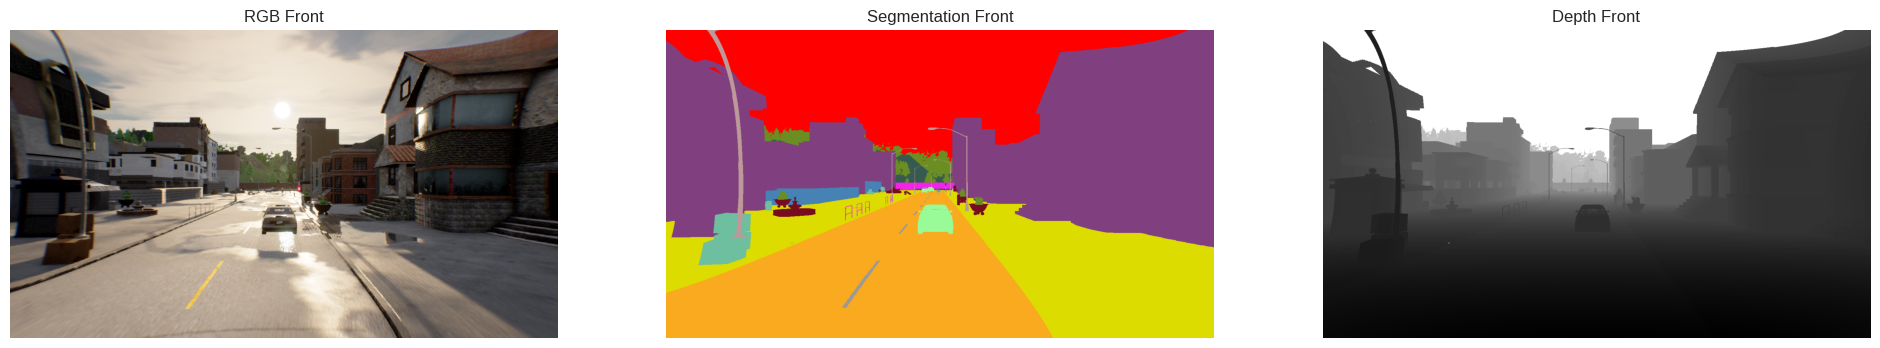

In [9]:
plt.style.use("seaborn-v0_8-whitegrid")
plt.figure(figsize=(24, 8))
plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(rgb_front, cv2.COLOR_BGR2RGB))
plt.title("RGB Front")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(seg_label2color(seg_front))
plt.title("Segmentation Front")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(np.log(normalized_depth), cmap="gray")
plt.title("Depth Front")
plt.axis("off")

Text(0.5, 1.0, 'Camera Trajectory')

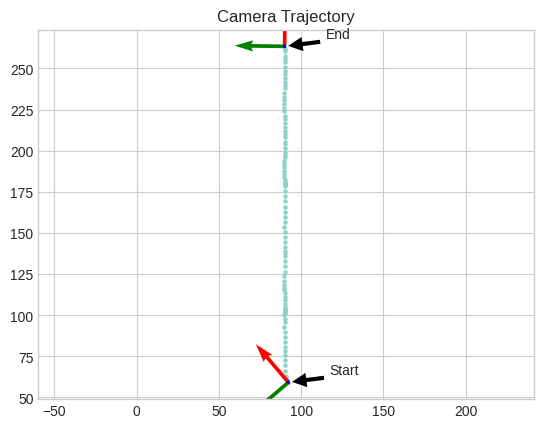

In [22]:
imgs, depths, masks, c2ws = [], [], [], []
for frame_idx in range(0, num_frames, 1):
    with open(os.path.join(scene_path, "ego_trans_matrix", f"{frame_idx:04d}.json")) as f:
        c2w = np.array(json.load(f))
        c2w[0, 3] += 1.5  # adds relative offset
        c2w[2, 3] += 2.0  # adds relative offset
        c2ws.append(c2w)
    
    rgb_front = cv2.imread(os.path.join(scene_path, "rgb_front", f"{frame_idx:04d}.png"))
    rgb_front = cv2.cvtColor(rgb_front, cv2.COLOR_BGR2RGB)
    imgs.append(rgb_front)
    
    depth_front = cv2.imread(os.path.join(scene_path, "depth_front", f"{frame_idx:04d}.png"))
    normalized_depth = (depth_front[:, :, 2] + depth_front[:, :, 1] * 256.0 + depth_front[:, :, 0] * 256.0 * 256.0) / (256.0 * 256.0 * 256.0 - 1)
    normalized_depth = normalized_depth * 1000.0  # in meters
    depths.append(normalized_depth)

    seg_front = cv2.imread(os.path.join(scene_path, "sem_seg_front", f"{frame_idx:04d}.png"))
    # seg_front = seg_label2color(seg_front)
    masks.append(seg_front)

fov = 90
H, W = rgb_front.shape[:2]
f = W / (2 * np.tan(np.deg2rad(fov/2)))
intrinsics = np.array([[f, 0, W/2], [0, f, H/2], [0, 0, 1]])
c2ws = np.stack(c2ws, axis=0)
imgs = np.stack(imgs, axis=0).transpose(0, 3, 1, 2)
depths = np.stack(depths, axis=0)[:, None]
masks = np.stack(masks, axis=0)

plt.style.use("seaborn-v0_8-whitegrid")
plt.figure()
plt.axis("equal")
plt.scatter(c2ws[:, 0, 3], c2ws[:, 1, 3], s=5)
# annotate start point and end point
plt.annotate("Start", xy=(c2ws[0, 0, 3], c2ws[0, 1, 3]), xytext=(c2ws[0, 0, 3] + 25, c2ws[0, 1, 3] + 5),
             arrowprops=dict(facecolor='black', shrink=0.05))
plt.annotate("End", xy=(c2ws[-1, 0, 3], c2ws[-1, 1, 3]), xytext=(c2ws[-1, 0, 3] + 25, c2ws[-1, 1, 3] + 5),
             arrowprops=dict(facecolor='black', shrink=0.05))

plt.quiver(c2ws[0, 0, 3], c2ws[0, 1, 3], c2ws[0, 0, 0], c2ws[0, 1, 0], angles='xy', scale_units='inches', scale=2, color='r', label='x')
plt.quiver(c2ws[0, 0, 3], c2ws[0, 1, 3], c2ws[0, 0, 1], c2ws[0, 1, 1], angles='xy', scale_units='inches', scale=2, color='g', label='y')
plt.quiver(c2ws[0, 0, 3], c2ws[0, 1, 3], c2ws[0, 0, 2], c2ws[0, 1, 2], angles='xy', scale_units='inches', scale=2, color='b', label='z')

plt.quiver(c2ws[-1, 0, 3], c2ws[-1, 1, 3], c2ws[-1, 0, 0], c2ws[-1, 1, 0], angles='xy', scale_units='inches', scale=2, color='r')
plt.quiver(c2ws[-1, 0, 3], c2ws[-1, 1, 3], c2ws[-1, 0, 1], c2ws[-1, 1, 1], angles='xy', scale_units='inches', scale=2, color='g')
plt.quiver(c2ws[-1, 0, 3], c2ws[-1, 1, 3], c2ws[-1, 0, 2], c2ws[-1, 1, 2], angles='xy', scale_units='inches', scale=2, color='b')

plt.title("Camera Trajectory")

In [24]:
print(c2ws[106])

[[ 4.26274817e-03 -9.99990940e-01 -2.47188268e-07  9.00172653e+01]
 [ 9.99990940e-01  4.26274817e-03  1.66999882e-06  1.79902069e+02]
 [-1.66892994e-06 -2.54304808e-07  1.00000000e+00  2.03341915e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


(9.202468872070312, 311.9460754394531)

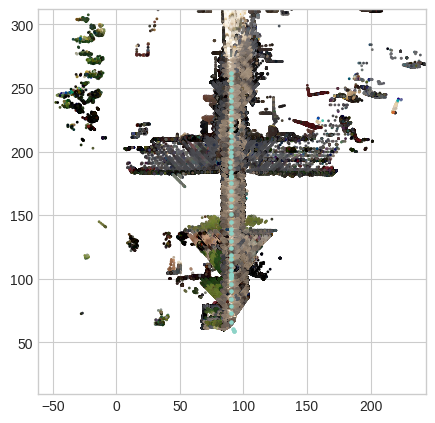

In [15]:
p_world, rgb_world = RGBD2PCD(torch.tensor(imgs, dtype=torch.float32), torch.tensor(depths, dtype=torch.float32), intrinsics, torch.tensor(c2ws, dtype=torch.float32))
pcd_mask = masks.reshape(-1, 3)[:, 0]
pcd_mask = pcd_mask != 13
pcd_xyz = p_world.cpu().numpy().reshape(-1, 3)[pcd_mask][::100]
pcd_rgb = rgb_world.cpu().numpy().reshape(-1, 3)[pcd_mask][::100]
plt.style.use("seaborn-v0_8-whitegrid")
plt.figure(figsize=(5, 5))
plt.axis("equal")
plt.scatter(pcd_xyz[:, 0], pcd_xyz[:, 1], c=pcd_rgb[:] / 255, s=1)
plt.scatter(c2ws[:, 0, 3], c2ws[:, 1, 3], s=5)
plt.xlim(c2ws[:, 0, 3].min() - 50, c2ws[:, 0, 3].max() + 50)
plt.ylim(c2ws[:, 1, 3].min() - 50, c2ws[:, 1, 3].max() + 50)

In [12]:
from plyfile import PlyData, PlyElement
# 确保输入数组形状正确
assert pcd_xyz.shape[0] == pcd_rgb.shape[0], "坐标和颜色数组的点数量不一致"
assert pcd_xyz.shape[1] == 3, "坐标数组应为(N, 3)"
assert pcd_rgb.shape[1] == 3, "颜色数组应为(N, 3)"

# 转换颜色到uint8（假设颜色值在0-255或0-1范围内）
if pcd_rgb.dtype != np.uint8:
    if np.max(pcd_rgb) <= 1.0:
        pcd_rgb = (pcd_rgb * 255).astype(np.uint8)
    else:
        pcd_rgb = pcd_rgb.astype(np.uint8)

# 创建结构化数组
vertex_dtype = [('x', 'f4'), ('y', 'f4'), ('z', 'f4'),
                ('red', 'u1'), ('green', 'u1'), ('blue', 'u1')]
vertices = np.empty(pcd_xyz.shape[0], dtype=vertex_dtype)

# 填充数据
vertices['x'] = pcd_xyz[:, 0].astype('f4')
vertices['y'] = pcd_xyz[:, 1].astype('f4')
vertices['z'] = pcd_xyz[:, 2].astype('f4')
vertices['red'] = pcd_rgb[:, 0]
vertices['green'] = pcd_rgb[:, 1]
vertices['blue'] = pcd_rgb[:, 2]

# 生成并保存PLY文件
ply_element = PlyElement.describe(vertices, 'vertex')
PlyData([ply_element]).write('colored_point_cloud.ply')

(-25.0, 25.0)

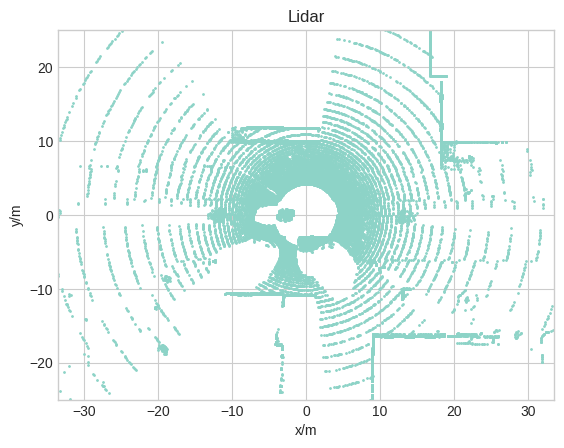

In [13]:
plt.figure()
plt.scatter(lidar[:, 0], lidar[:, 1], s=1)
plt.xlabel("x/m")
plt.ylabel("y/m")
plt.title("Lidar")
plt.axis("equal")
plt.xlim(-25, 25)
plt.ylim(-25, 25)

In [14]:
if not os.path.exists(os.path.join(scene_path, 'input')):
    os.makedirs(os.path.join(scene_path, 'input'))

fourcc = cv2.VideoWriter_fourcc(*"mp4v")
H, W = fov_transform(cv2.imread(os.path.join(scene_path, "rgb_front", "0000.png"))).shape[:2]
# video = cv2.VideoWriter(os.path.join(scene_path, 'video.mp4'), fourcc, 30, (W, H))
for idx in tqdm(range(num_frames)):
    rgb_image = fov_transform(cv2.imread(os.path.join(scene_path, "rgb_front", f"{idx:04d}.png")))
    cv2.imwrite(os.path.join(scene_path, 'input', f"{idx:04d}.png"), rgb_image)
    # video.write(rgb_image)
# video.release()
# print(f"Video saved to {os.path.join(scene_path, 'video.mp4')}")

100%|██████████| 190/190 [00:09<00:00, 20.17it/s]
